In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 735 ms, sys: 276 ms, total: 1.01 s
Wall time: 1.97 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.25 s, sys: 954 ms, total: 7.2 s
Wall time: 9.19 s


In [5]:
class DeepFM(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(DeepFM, self).__init__()
        
        num_fileds = len(field_dims)
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        
        self.fm = EmbeddingsInteraction()
        
        self.deep = MultiLayerPerceptron([embed_dim * num_fileds, 128, 64, 32])
        self.fc = nn.Linear(1 + num_fileds * (num_fileds - 1) // 2 + 32, 1)

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)

        embeddings = self.embed2(x)
        embeddings_cross = self.fm(embeddings).sum(dim=-1)
        deep_output = self.deep(embeddings.reshape(x.shape[0], -1))
        
        stacked = torch.hstack([self.embed1(x).sum(dim=1), embeddings_cross, deep_output])
        output = self.fc(stacked)
        output = torch.sigmoid(output)
        return output


 17%|█▋        | 103/600 [00:47<03:49,  2.17it/s]


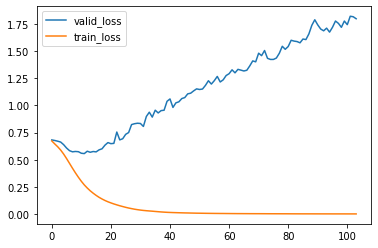

train_loss: 0.65296 | train_metric: 0.91730
valid_loss: 0.66251 | valid_metric: 0.74479
test_loss:  0.66119 | test_auc:  0.75679
CPU times: user 46.9 s, sys: 271 ms, total: 47.2 s
Wall time: 47.9 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

dfm = DeepFM(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(dfm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(dfm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
